In [45]:
import pandas as pd
import numpy as np
import yfinance as yf


#Taking CityBank and WellsFargo stocks from yahoo finance
CB = yf.download("C", start="2015-01-01", end="2024-04-01", interval="1d")
WF = yf.download("WFC", start="2015-01-01", end="2024-04-01", interval="1d")

# Taking the closing prices
CB_closing = CB['Close']
WF_closing = WF['Close']

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [46]:
CB_closing

Date
2015-01-02    54.259998
2015-01-05    52.549999
2015-01-06    50.700001
2015-01-07    51.169998
2015-01-08    51.939999
                ...    
2024-03-22    60.820000
2024-03-25    60.950001
2024-03-26    61.660000
2024-03-27    62.750000
2024-03-28    63.240002
Name: Close, Length: 2325, dtype: float64

In [47]:
WF_closing

Date
2015-01-02    54.700001
2015-01-05    53.200001
2015-01-06    52.090000
2015-01-07    52.400002
2015-01-08    53.560001
                ...    
2024-03-22    57.130001
2024-03-25    56.730000
2024-03-26    56.680000
2024-03-27    57.610001
2024-03-28    57.959999
Name: Close, Length: 2325, dtype: float64

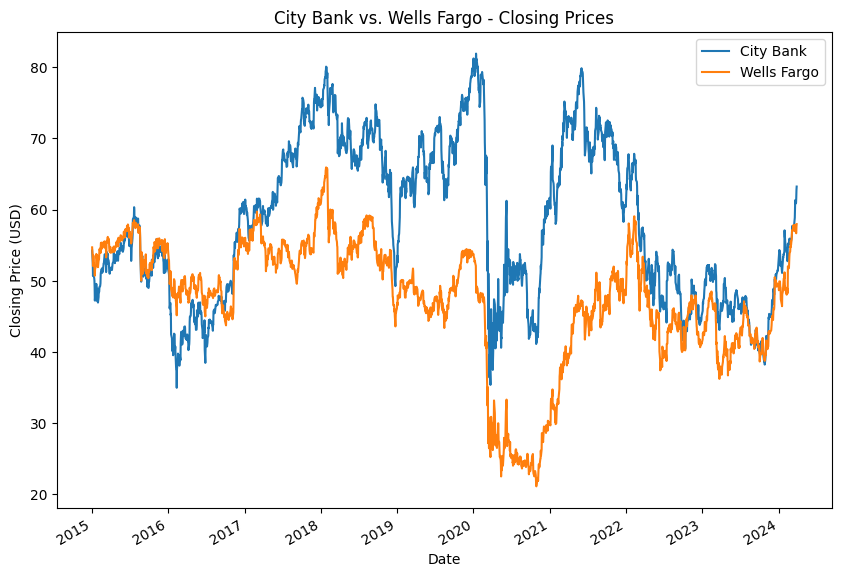

In [48]:
import matplotlib.pyplot as plt

# Plotting the closing prices of CB and WFC
CB_closing.plot(figsize=(10, 7), legend=True, title='City Bank vs. Wells Fargo - Closing Prices')
WF_closing.plot(legend=True)

plt.legend(['City Bank', 'Wells Fargo'])
plt.ylabel('Closing Price (USD)')
plt.show()


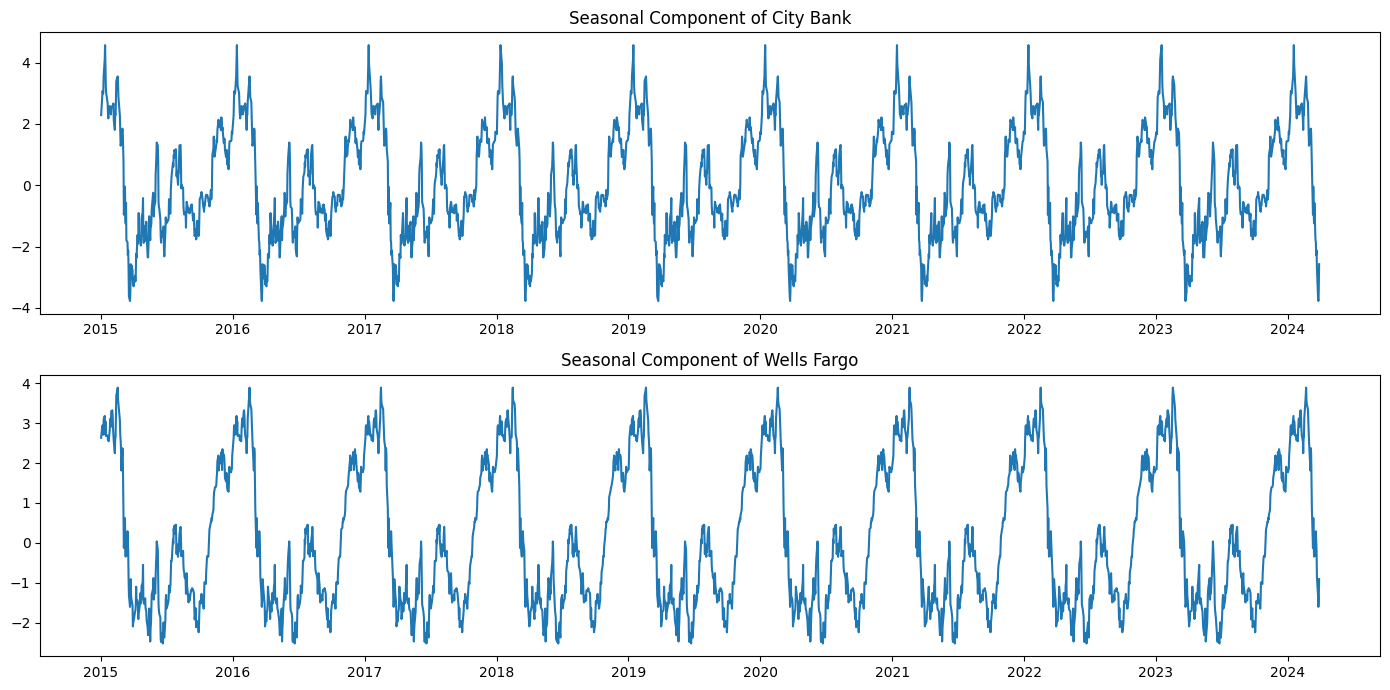

In [49]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decompose_CB = seasonal_decompose(CB_closing, model='additive', period=252)
decompose_WF = seasonal_decompose(WF_closing, model='additive', period=252)

# Plot the seasonal component
plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(decompose_CB.seasonal)
plt.title('Seasonal Component of City Bank')

plt.subplot(2, 1, 2)
plt.plot(decompose_WF.seasonal)
plt.title('Seasonal Component of Wells Fargo')

plt.tight_layout()
plt.show()

1. The graphs show the seasonal patterns in the stock prices of City Bank and Wells Fargo. These patterns are repeating fluctuations or trends that occur at regular times across time.
2. Both plots demonstrate some seasonality, with peaks and troughs occurring at consistent times throughout the year.
3. The frequent occurrence of seasonal trends suggests that adding them into forecasting models, such as the Seasonal AutoRegressive Integrated Moving Average (SARIMA), may improve prediction accuracy.



<h4>Checking the stationary of the data</h4>

In [50]:
from statsmodels.tsa.stattools import adfuller

In [51]:
stat_test = adfuller(CB_closing)
print('The test statistic is {}'.format(stat_test[0]))
print('The p-value is {}'.format(stat_test[1]))

The test statistic is -2.7724020729772083
The p-value is 0.062325353131365994


The p-value is higher than the common level of 0.05 so the City Bank data is not stationary

In [52]:
stat_test = adfuller(WF_closing)
print('The test statistic is {}'.format(stat_test[0]))
print('The p-value is {}'.format(stat_test[1]))

The test statistic is -2.1796824138628748
The p-value is 0.21370202874349986


Similarly, The wells Fargo data p-value is also higher it is also non stationary

Since both the data are not stationary we have to make the data stationary

In [53]:
WF_closing

Date
2015-01-02    54.700001
2015-01-05    53.200001
2015-01-06    52.090000
2015-01-07    52.400002
2015-01-08    53.560001
                ...    
2024-03-22    57.130001
2024-03-25    56.730000
2024-03-26    56.680000
2024-03-27    57.610001
2024-03-28    57.959999
Name: Close, Length: 2325, dtype: float64

In [54]:
CB_closing_diff = CB_closing.diff(12).dropna()
WF_closing_diff = WF_closing.diff(12).dropna()

In [55]:
stat_test = adfuller(CB_closing_diff)
print('The test statistic is {}'.format(stat_test[0]))
print('The p-value is {}'.format(stat_test[1]))

The test statistic is -7.605308361833576
The p-value is 2.3307577085894582e-11


In [56]:
stat_test = adfuller(WF_closing_diff)
print('The test statistic is {}'.format(stat_test[0]))
print('The p-value is {}'.format(stat_test[1]))

The test statistic is -7.227533465046744
The p-value is 2.0345431009378796e-10


After taking out the difference we can observe that both the data of city bank and Wells Fargo are stationary

<h4> To Analyze the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF)</h4>

In [57]:
import statsmodels.api as sm

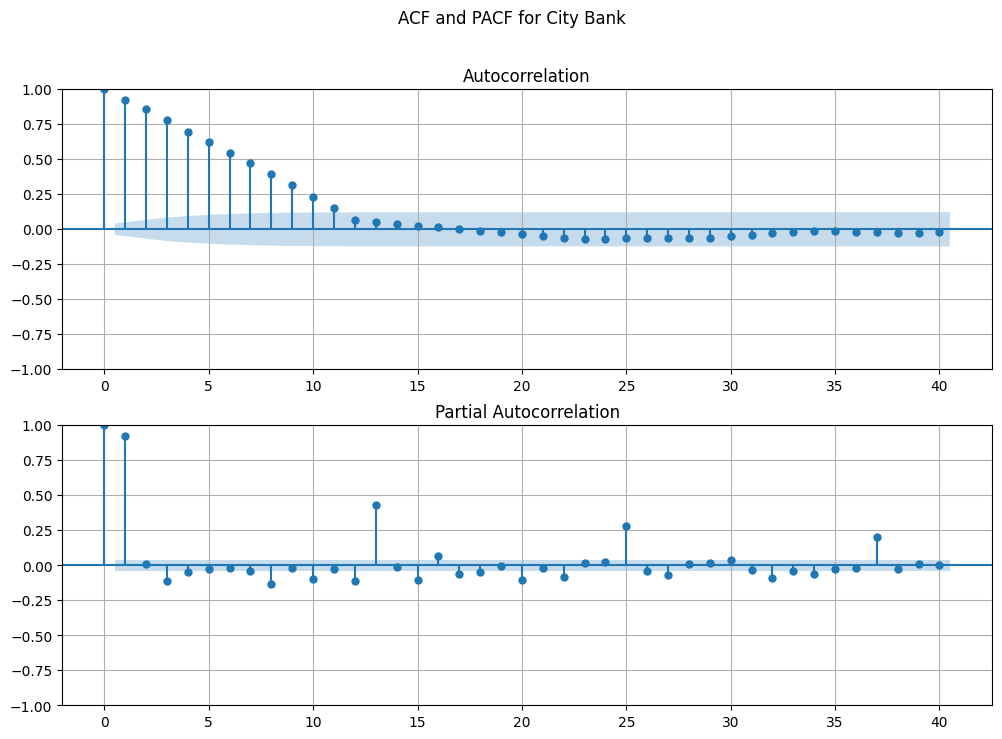

In [58]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('ACF and PACF for City Bank')
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(CB_closing_diff.iloc[13:],lags=40,ax=ax1)
plt.grid(True)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(CB_closing_diff.iloc[13:],lags=40,ax=ax2)
plt.grid(True)


1. For ACF plot of  City Bank's differenced data extends gradually towards zero which indicates that the MA componenet for SARIMA model would be 0
2. For PACF plot it occurs after the first lag, which wouldm indicates that AR would be 1


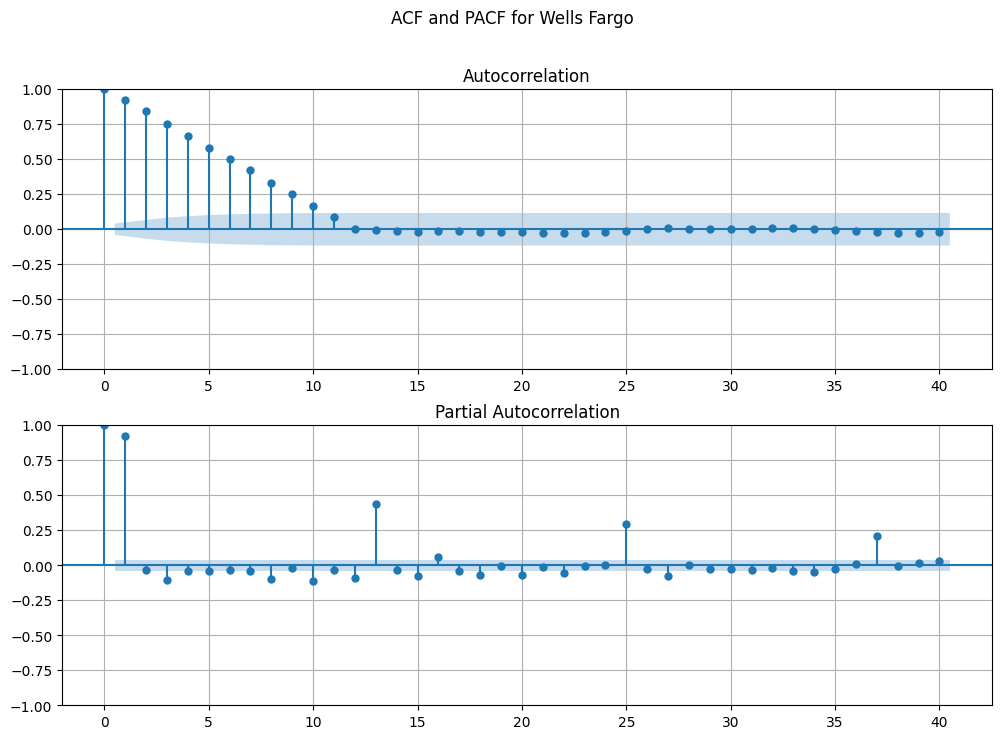

In [59]:
fig = plt.figure(figsize=(12,8))
fig.suptitle('ACF and PACF for Wells Fargo')
ax1 = fig.add_subplot(211)
sm.graphics.tsa.plot_acf(WF_closing_diff.iloc[13:],lags=40,ax=ax1)
plt.grid(True)
ax2 = fig.add_subplot(212)
sm.graphics.tsa.plot_pacf(WF_closing_diff.iloc[13:],lags=40,ax=ax2)
plt.grid(True)

1. Similarly, For ACF plot of  Wells Fargo's differenced data extends gradually towards zero which indicates that the MA componenet for SARIMA model would be 0
2. Similarly, For PACF plot it occurs after the first lag, which wouldm indicates that AR would be 1


**IMPLEMENTING SARIMA**

In [60]:
# Split data into train and test sets
CB_train = CB_closing_diff[:-90]
CB_test = CB_closing_diff[-90:]

WF_train = WF_closing_diff[:-90]
WF_test = WF_closing_diff[-90:]

We have taken the order of (1,1,0) from the ACF and PACF plots of the banks respectively and the seasonal component value would be 12 as we have differenced 12 from the closing prices

In [61]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
# Fit a SARIMA model for City Bank
CB_sarima_model = SARIMAX(CB_train, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
CB_sarima_results = CB_sarima_model.fit(disp=0)

# Fit a SARIMA model for Wells Fargo
WF_sarima_model = SARIMAX(WF_train, order=(1, 1, 0), seasonal_order=(1, 1, 0, 12))
WF_sarima_results = WF_sarima_model.fit(disp=0)


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning:

A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.



In [62]:
from sklearn.metrics import mean_squared_error

# Predict on the test set for City Bank
CB_predictions = CB_sarima_results.get_forecast(steps=90)
CB_predicted_mean = CB_predictions.predicted_mean
CB_predicted_mean.index = CB_test.index


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [63]:
# Calculate RMSE for City Bank
CB_rmse = np.sqrt(mean_squared_error(CB_test, CB_predicted_mean))
print(f'City Bank Test RMSE: {CB_rmse}')


City Bank Test RMSE: 15.584308480917725


In [64]:
# Predict on the test set for Wells Fargo
WF_predictions = WF_sarima_results.get_forecast(steps=90)
WF_predicted_mean = WF_predictions.predicted_mean
WF_predicted_mean.index = WF_test.index


/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning:

No supported index is available. Prediction results will be given with an integer index beginning at `start`.

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:836: FutureWarning:

No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.



In [65]:
# Calculate RMSE for Wells Fargo
WF_rmse = np.sqrt(mean_squared_error(WF_test, WF_predicted_mean))
print(f'Wells Fargo Test RMSE: {WF_rmse}')

Wells Fargo Test RMSE: 8.757585708950899


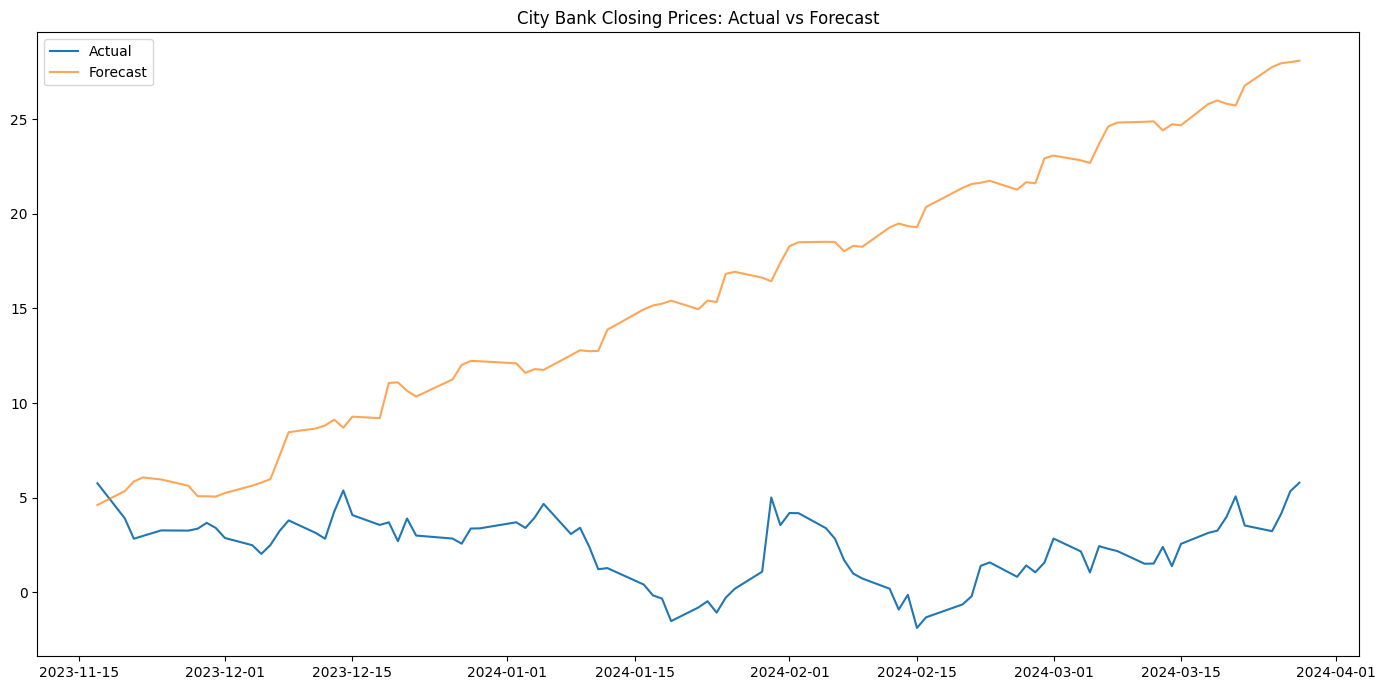

In [66]:
# If you want to visualize the forecasts along with the actual test data, you can use matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize=(14, 7))

# Plot City Bank actual vs. predicted

plt.plot(CB_test, label='Actual')
plt.plot(CB_predicted_mean, label='Forecast', alpha=0.7)
plt.title('City Bank Closing Prices: Actual vs Forecast')
plt.legend()

plt.tight_layout()
plt.show()



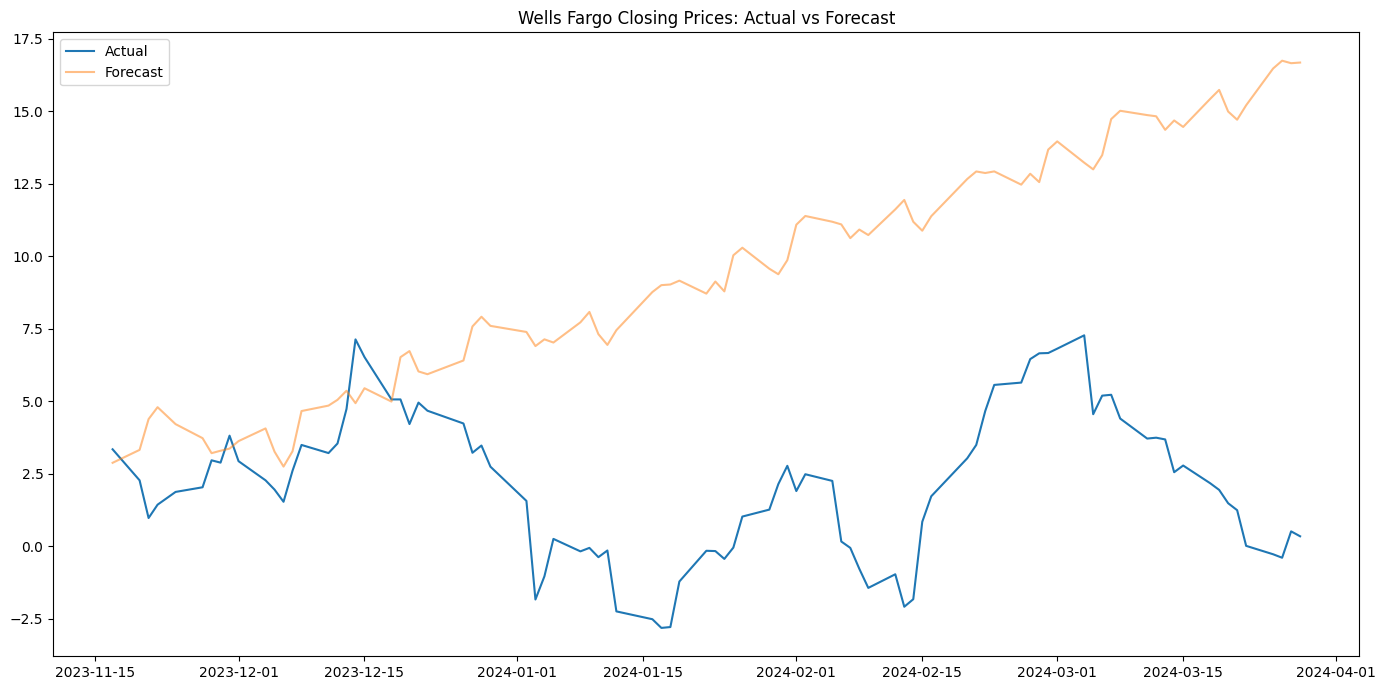

In [67]:
# Plot Wells Fargo actual vs. predicted
plt.figure(figsize=(14, 7))
plt.plot(WF_test, label='Actual')
plt.plot(WF_predicted_mean, label='Forecast', alpha=0.5)
plt.title('Wells Fargo Closing Prices: Actual vs Forecast')
plt.legend()

plt.tight_layout()
plt.show()


In [68]:

import plotly.graph_objects as go

# Create the figure object
fig = go.Figure()

# Add City Bank train and test data to the figure
fig.add_trace(go.Scatter(x=CB_train.index, y=CB_train.values, name='City Bank Train', mode='lines'))
fig.add_trace(go.Scatter(x=CB_test.index, y=CB_test.values, name='City Bank Test', mode='lines'))

# Add Wells Fargo train and test data to the figure
fig.add_trace(go.Scatter(x=WF_train.index, y=WF_train.values, name='Wells Fargo Train', mode='lines'))
fig.add_trace(go.Scatter(x=WF_test.index, y=WF_test.values, name='Wells Fargo Test', mode='lines'))

# Add forecast data to the figure
fig.add_trace(go.Scatter(x=CB_test.index, y=CB_predicted_mean, name='City Bank Forecast', mode='lines'))
fig.add_trace(go.Scatter(x=WF_test.index, y=WF_predicted_mean, name='Wells Fargo Forecast', mode='lines'))

# Set plot title and axis labels
fig.update_layout(title='City Bank and Wells Fargo SARIMAX Forecast', xaxis_title='Date', yaxis_title='Closing Price')

# Show the plot
fig.show()


The performance of SARIMA is poor so we have implemented LSTM

**IMPLEMENTING LSTM**

In [69]:
# create a new DataFrame with the closing prices of both stocks
df = pd.concat([CB_closing, WF_closing], axis=1)
df.columns = ['C', 'WFC']
df.isna().sum()
len(df)

2325

In [70]:
# split the data into training and testing sets
train_data = df.iloc[:1700, :]
test_data = df.iloc[1700:, :]

In [71]:
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM
# scale the data
scaler = MinMaxScaler()
train_scaled = scaler.fit_transform(train_data)
test_scaled = scaler.transform(test_data)

In [72]:
# create training and testing data for the LSTM model
X_train = []
y_train = []
for i in range(60, train_scaled.shape[0]):
    X_train.append(train_scaled[i-60:i, :])
    y_train.append(train_scaled[i, :])

X_train, y_train = np.array(X_train), np.array(y_train)

X_test = []
y_test = []
for i in range(60, test_scaled.shape[0]):
    X_test.append(test_scaled[i-60:i, :])
    y_test.append(test_scaled[i, :])

X_test, y_test = np.array(X_test), np.array(y_test)


In [73]:
# build the LSTM model
model = Sequential()

model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=2))

model.compile(loss='mean_squared_error', optimizer='adam')

# train the model
history = model.fit(X_train, y_train, epochs=30, batch_size=32, validation_split=0.1)

Epoch 1/30
47/47 [==============================] - 11s 101ms/step - loss: 0.0382 - val_loss: 0.0039
Epoch 2/30
47/47 [==============================] - 4s 89ms/step - loss: 0.0046 - val_loss: 0.0055
Epoch 3/30
47/47 [==============================] - 4s 81ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 4/30
47/47 [==============================] - 4s 75ms/step - loss: 0.0033 - val_loss: 0.0045
Epoch 5/30
47/47 [==============================] - 4s 81ms/step - loss: 0.0028 - val_loss: 0.0035
Epoch 6/30
47/47 [==============================] - 4s 88ms/step - loss: 0.0026 - val_loss: 0.0047
Epoch 7/30
47/47 [==============================] - 4s 76ms/step - loss: 0.0026 - val_loss: 0.0024
Epoch 8/30
47/47 [==============================] - 4s 76ms/step - loss: 0.0025 - val_loss: 0.0047
Epoch 9/30
47/47 [==============================] - 4s 95ms/step - loss: 0.0022 - val_loss: 0.0050
Epoch 10/30
47/47 [==============================] - 4s 76ms/step - loss: 0.0021 - val_loss: 0.0059
Epoch 1

In [74]:
predictions = model.predict(X_test)
predictions = scaler.inverse_transform(predictions)
y_true = scaler.inverse_transform(y_test)

18/18 [==============================] - 1s 22ms/step


In [75]:
# forecast the stock prices for the next 120 days
forecast_data = []
last_120_days = test_data[-120:].values
last_120_days_scaled = scaler.transform(last_120_days)

for i in range(120):
    X = np.array([last_120_days_scaled])
    X = np.reshape(X, (X.shape[0], X.shape[1], 2))

    y_pred = model.predict(X)
    y_pred = scaler.inverse_transform(y_pred)

    last_120_days = np.append(last_120_days, y_pred, axis=0)
    last_120_days = last_120_days[1:]

    last_120_days_scaled = scaler.transform(last_120_days)

    forecast_data.append(y_pred)

forecast_data = np.array(forecast_data)
forecast_data = np.reshape(forecast_data, (forecast_data.shape[0], forecast_data.shape[2]))
print(test_data.index[:-120])
print(len(forecast_data))

# create a new DataFrame with the predicted and forecasted stock prices
pred_data = pd.DataFrame(predictions, index=test_data.index[:-60], columns=['CB_pred', 'WF_pred'])
forecast_index = pd.date_range(start=test_data.index[-1], periods=len(forecast_data), freq='D')
forecast_data = pd.DataFrame(forecast_data, index=forecast_index, columns=['CB_pred', 'WF_pred'])

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 41ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 35ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 38ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 37ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 54ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 51ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 47ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 50ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 53ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 48ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 31ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 34ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 33ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



1/1 [==============================] - 0s 32ms/step
DatetimeIndex(['2021-10-04', '2021-10-05', '2021-10-06', '2021-10-07',
               '2021-10-08', '2021-10-11', '2021-10-12', '2021-10-13',
               '2021-10-14', '2021-10-15',
               ...
               '2023-09-22', '2023-09-25', '2023-09-26', '2023-09-27',
               '2023-09-28', '2023-09-29', '2023-10-02', '2023-10-03',
               '2023-10-04', '2023-10-05'],
              dtype='datetime64[ns]', name='Date', length=505, freq=None)
120


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning:

X does not have valid feature names, but MinMaxScaler was fitted with feature names



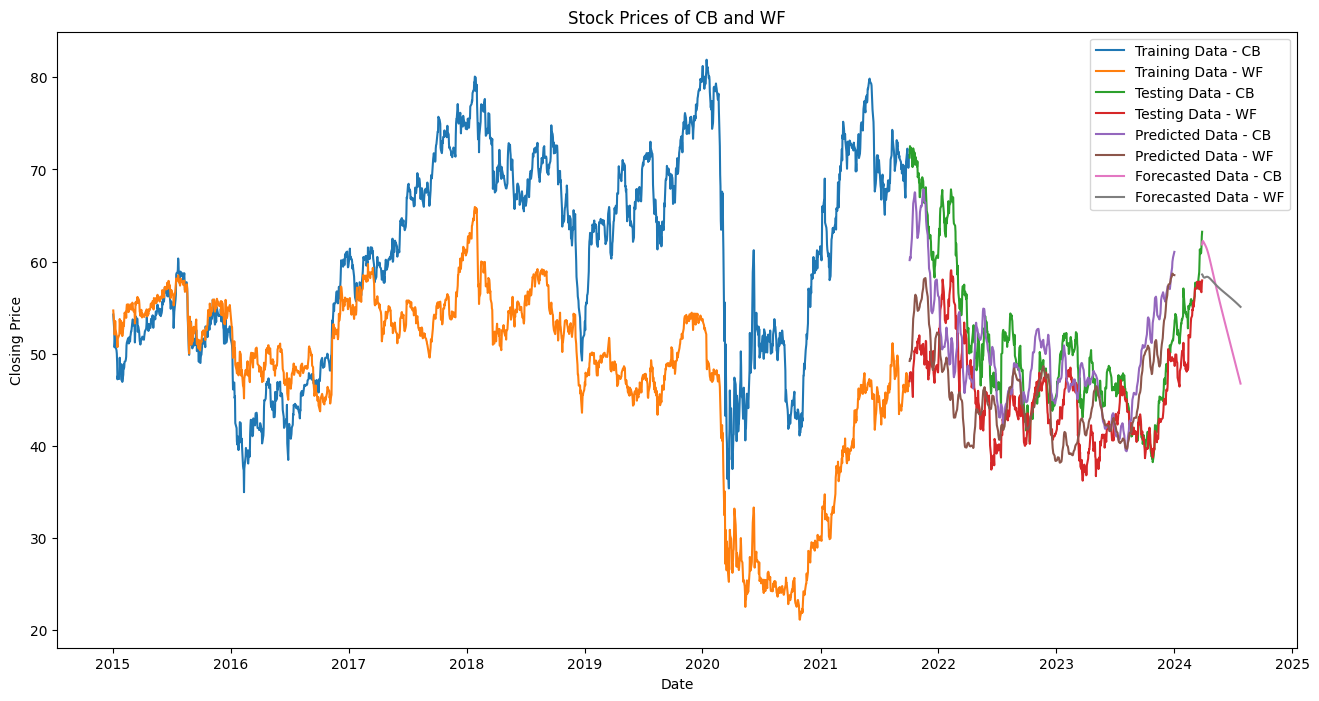

In [76]:
# plot the graph
plt.figure(figsize=(16,8))
plt.title('Stock Prices of CB and WF')
plt.xlabel('Date')
plt.ylabel('Closing Price')
plt.plot(train_data.index, train_data['C'], label='Training Data - CB')
plt.plot(train_data.index, train_data['WFC'], label='Training Data - WF')
plt.plot(test_data.index, test_data['C'], label='Testing Data - CB')
plt.plot(test_data.index, test_data['WFC'], label='Testing Data - WF')
plt.plot(pred_data.index, pred_data['CB_pred'], label='Predicted Data - CB')
plt.plot(pred_data.index, pred_data['WF_pred'], label='Predicted Data - WF')
plt.plot(forecast_data.index, forecast_data['CB_pred'], label='Forecasted Data - CB')
plt.plot(forecast_data.index, forecast_data['WF_pred'], label='Forecasted Data - WF')
plt.legend()
plt.show()

In [77]:
#The same plot is plotted using plotly for better understanding
import plotly.graph_objects as go

# create the traces
plot = [
    go.Scatter(x=train_data.index, y=train_data['C'], name='Training Data - CB'),
    go.Scatter(x=test_data.index, y=test_data['C'], name='Testing Data - CB'),
    go.Scatter(x=pred_data.index, y=pred_data['CB_pred'], name='Predicted Data - CB'),
    go.Scatter(x=forecast_data.index, y=forecast_data['CB_pred'], name='Forecasted Data - CB')
]

# create the figure
fig = go.Figure(data=plot)

# update the layout
fig.update_layout(
    title='Stock Prices of City Bank',
    xaxis_title='Date',
    yaxis_title='Closing Price'
)

# display the figure
fig.show()

In [78]:
#The same plot is plotted using plotly for better understanding
import plotly.graph_objects as go

# create the traces
plot = [
    go.Scatter(x=train_data.index, y=train_data['WFC'], name='Training Data - WF'),
    go.Scatter(x=test_data.index, y=test_data['WFC'], name='Testing Data - WF'),
    go.Scatter(x=pred_data.index, y=pred_data['WF_pred'], name='Predicted Data - WF'),
    go.Scatter(x=forecast_data.index, y=forecast_data['WF_pred'], name='Forecasted Data - WF')
]

# create the figure
fig = go.Figure(data=plot)

# update the layout
fig.update_layout(
    title='Stock Prices of WFC',
    xaxis_title='Date',
    yaxis_title='Closing Price'
)

# display the figure
fig.show()

In [79]:
# calculate the mean squared error and root mean squared error
CB_mse = mean_squared_error(y_true[:,0], predictions[:,0])
CB_rmse = np.sqrt(CB_mse)
print(f"Root Mean Squared Error for CB: {CB_rmse:.2f}")

WF_mse = mean_squared_error(y_true[:,1], predictions[:,1])
WF_rmse = np.sqrt(WF_mse)
print(f"Root Mean Squared Error for WF: {WF_rmse:.2f}")

Root Mean Squared Error for CB: 1.32
Root Mean Squared Error for WF: 1.62


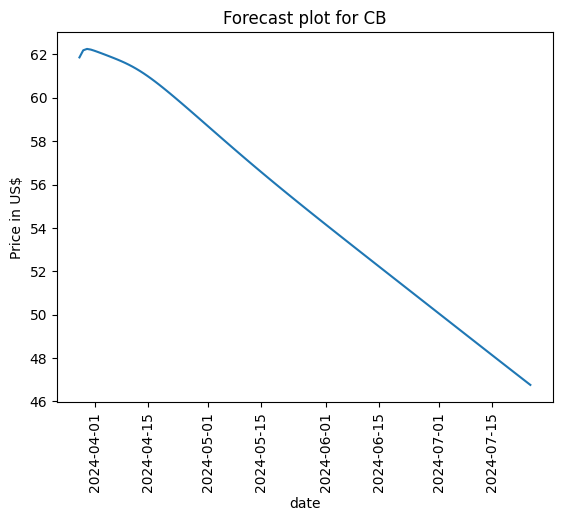

In [80]:
plt.plot(forecast_data['CB_pred'])
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('Price in US$')
plt.title('Forecast plot for CB')
plt.show()

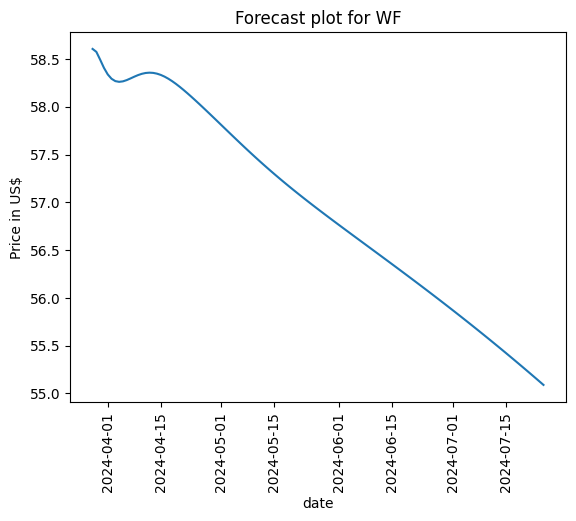

In [81]:
plt.plot(forecast_data['WF_pred'])
plt.xticks(rotation=90)
plt.xlabel('date')
plt.ylabel('Price in US$')
plt.title('Forecast plot for WF')
plt.show()

1. According to the RMSE values, the LSTM model outperformed the SARIMA model in projecting the closing stock prices of both banks.

2. The smaller RMSE number suggests that City Bank's LSTM model forecast was somewhat more accurate than Wells Fargo's.
